In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import os


In [3]:
# Create a dataset of all examples

dataset_path = Path("../150")

def get_size(start_path = '.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)

    return total_size

print(get_size(dataset_path)/(1000**3), 'G')                 

18.141022422 G


In [4]:
examples = [f.absolute() for f in (dataset_path / "neighborhoods").glob("*.txt.gz")]
intensities = [None] * len(examples)
source_cam = [None] * len(examples)
target_cam = [None] * len(examples)

for i in trange(len(examples), desc="processing"):
    filename = examples[i].stem
    source_cam[i] = filename.split("_")[0]
    target_cam[i] = filename.split("_")[1]
    intensities[i] = filename.split("_")[2]
    
df = pd.DataFrame()
df['examples'] = examples
df['source_cam'] = source_cam
df['target_cam'] = target_cam
df['target_intensity'] = intensities
df["source_cam"] = pd.to_numeric(df["source_cam"])
df["target_cam"] = pd.to_numeric(df["target_cam"])
df["target_intensity"] = pd.to_numeric(df["target_intensity"])
df.to_csv(dataset_path / "master.csv")

print(df.head())
print(df.tail())

processing: 100%|██████████| 1993653/1993653 [00:02<00:00, 779241.50it/s]


                                            examples source_cam target_cam  \
0  /home/david/bin/python/intensity/src/dataset/n...         16         16   
1  /home/david/bin/python/intensity/src/dataset/n...         40         40   
2  /home/david/bin/python/intensity/src/dataset/n...         22         22   
3  /home/david/bin/python/intensity/src/dataset/n...         21         21   
4  /home/david/bin/python/intensity/src/dataset/n...         19         19   

  target_intensity  
0              264  
1              270  
2              380  
3              112  
4              318  
                                                  examples source_cam  \
1993648  /home/david/bin/python/intensity/src/dataset/n...         34   
1993649  /home/david/bin/python/intensity/src/dataset/n...         10   
1993650  /home/david/bin/python/intensity/src/dataset/n...         32   
1993651  /home/david/bin/python/intensity/src/dataset/n...         30   
1993652  /home/david/bin/python/intensit

In [5]:
# Check balance between camera pairs
camera_d = {}
for i in trange(len(df), desc="counting camera pair examples"):
    row = df.iloc[i]
    current_pair = (row['source_cam'], row['target_cam'])

    if current_pair not in camera_d:
        camera_d[current_pair] = 1
    else:
        camera_d[current_pair] += 1


counting camera pair examples: 100%|██████████| 1993653/1993653 [02:59<00:00, 11086.41it/s]


In [26]:
# if there is not enough overlap, remove this key from consideration
overlap = {}
noverlap = {}

for key, value in camera_d.items():
    if key[1] == '1': 
        overlap[key[0]] = value
    else:
        noverlap[key[0]] = value
        
f_overlap = {}
f_noverlap = {}
for key, value in overlap.items():
    if value > 40000:
        f_overlap[key] = value
        f_noverlap[key] = noverlap[key]



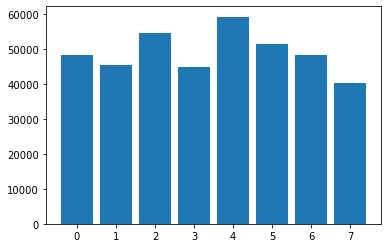

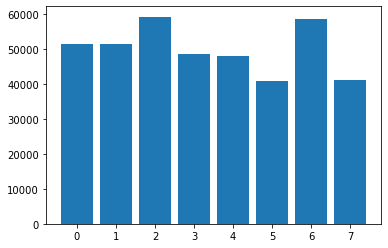

15
dict_keys(['0', '27', '39', '26', '15', '40', '30', '32'])
dict_keys(['0', '27', '39', '26', '15', '40', '30', '32'])


In [61]:
plt.bar(range(len(f_overlap.keys())), f_overlap.values())
plt.show()
plt.bar(range(len(f_noverlap.keys())), f_noverlap.values())
plt.show()
my_scans = f_overlap.keys()
max_scan = max(f_overlap, key=f_overlap.get)
print(max_scan)
print(my_scans)
print(f_noverlap.keys())

['0', '27', '39', '26', '15', '40', '30', '32']
0


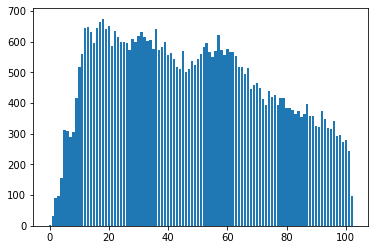

27


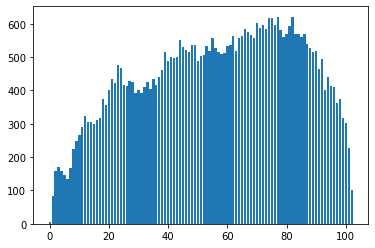

39


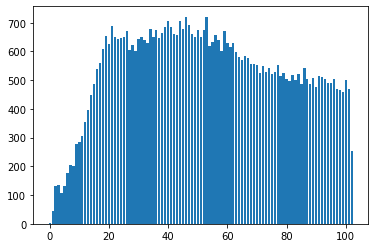

26


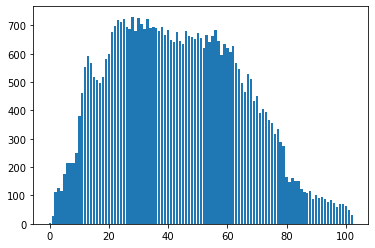

15


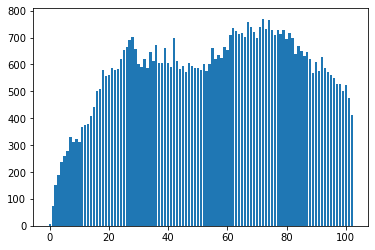

40


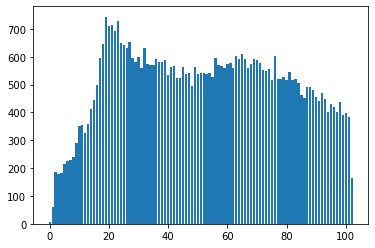

30


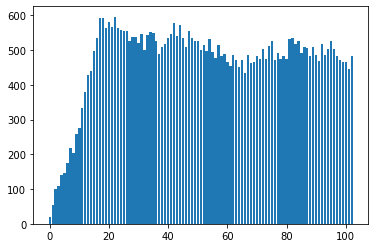

32


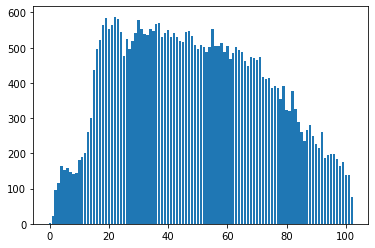

In [42]:
# show coverage of intensities for each of these
# start with the coverage in the overlap region:
bins = np.arange(0, 520, 5)
scans = list(my_scans)
print(scans)

for scan in scans:
    curr_df = df.loc[(df.source_cam == scan) & (df.target_cam == '1')]

    coverage = {}
    for i in range(len(bins)-1):
        left, right = bins[i], bins[i+1]
        count = len(curr_df.loc[(curr_df.target_intensity < right) & (curr_df.target_intensity >= left)])
        coverage[i] = count
    print(scan)
    plt.bar(range(len(coverage.keys())), coverage.values())
    plt.show()

    

In [49]:
# dict_keys(['0', '27', '39', '26', '15', '40', '30', '32'])
my_df = df.loc[(df["source_cam"]=='0') | 
               (df["source_cam"]=='27') | 
               (df["source_cam"]=='39') | 
               (df["source_cam"]=='26') | 
               (df["source_cam"]=='15') | 
               (df["source_cam"]=='40') | 
               (df["source_cam"]=='30') | 
               (df["source_cam"]=='32')]

print(len(df))
print(len(my_df))

1993653
792869


In [56]:
# divide into training, validation, and testing
my_df.sample(frac=1)

sample_count = len(my_df)
split_point = sample_count - sample_count//5
df_train = my_df.iloc[:split_point, :].reset_index(drop=True)
df_test = my_df.iloc[split_point:, :].reset_index(drop=True)

val_split_point = len(df_train) - len(df_train)//5
df_val = df_train.iloc[val_split_point:, :].reset_index(drop=True)
df_train = df_train.iloc[:val_split_point, :].reset_index(drop=True)

print(f"Training samples pre-resampling: {len(df_train)}")
print(f"Validation samples pre-resampling: {len(df_val)}")
print(f"Testing samples pre-resampling: {len(df_test)}")

Training samples pre-resampling: 507437
Validation samples pre-resampling: 126859
Testing samples pre-resampling: 158573


In [64]:
# resample df_train to have balanced target_intensity coverage
# show coverage of intensities for each of these
# start with the coverage in the overlap region:
df_train_resample = df_train.copy()
bins = np.arange(0, 520, 5)
scans = list(my_scans)
print(scans)

for scan in scans:
    curr_df = df_train.loc[(df_train.source_cam == scan) & (df_train.target_cam == '1')]

    coverage = {}
    new_coverage = {}
    for i in range(len(bins)-1):
        left, right = bins[i], bins[i+1]
        count = len(curr_df.loc[(curr_df.target_intensity < right) & (curr_df.target_intensity >= left)])
        coverage[i] = count
        
    max_bin = max(coverage, key=coverage.get)
    max_value = coverage[max_bin]
    
    for i in range(len(bins)-1):
        if i != max_bin:
            left, right = bins[i], bins[i+1]
            # select rows with intensity in bins
            curr_df_ti = curr_df.loc[(curr_df.target_intensity < right) & (curr_df.target_intensity >= left)]
            
            # oversample
            curr_df_ti = curr_df_ti.sample(n=max_value-coverage[i], replace=True)  # add some noise?
            
            # append
            df_train_resample = df_train_resample.append(curr_df_ti, ignore_index=True)
            
print(len(df_train))
print(len(df_train_resample))

['0', '27', '39', '26', '15', '40', '30', '32']
626083


In [65]:
print(len(df_train))

507437


0


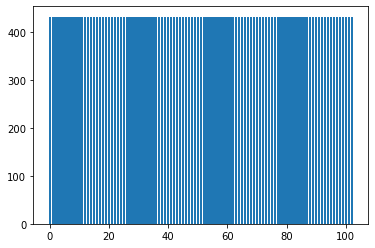

27


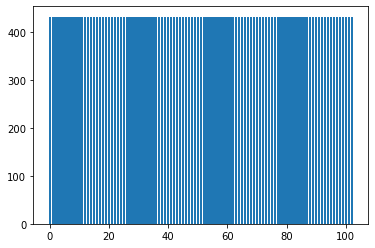

39


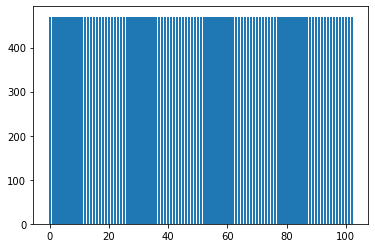

26


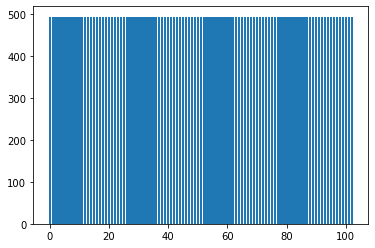

15


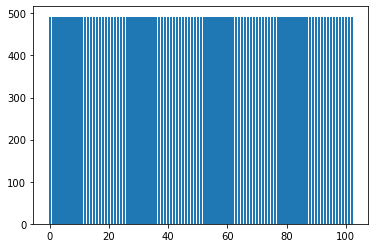

40


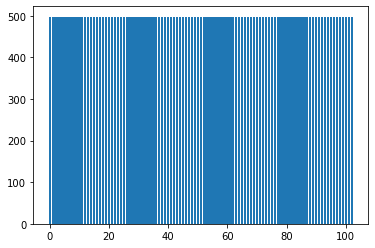

30


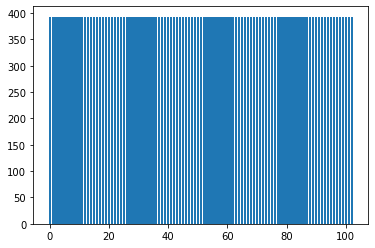

32


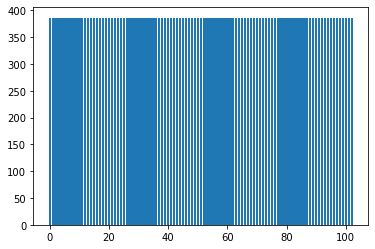

In [66]:
for scan in scans:
    curr_df = df_train_resample.loc[(df_train_resample.source_cam == scan) & (df_train_resample.target_cam == '1')]

    coverage = {}
    for i in range(len(bins)-1):
        left, right = bins[i], bins[i+1]
        count = len(curr_df.loc[(curr_df.target_intensity < right) & (curr_df.target_intensity >= left)])
        coverage[i] = count
    
    print(scan)
    plt.bar(range(len(coverage.keys())), coverage.values())
    plt.show()

In [67]:
df.to_csv(dataset_path / "master.csv")
df_test.to_csv(dataset_path / "test.csv")
df_val.to_csv(dataset_path / "val.csv")
df_train_resample.to_csv(dataset_path / "train.csv")